<a href="https://colab.research.google.com/github/rhiats/breastCancerClassification/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.5 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
bc_data = load_breast_cancer()
df = pd.DataFrame(bc_data.data, columns=bc_data.feature_names)
df['Target'] = bc_data.target
df.insert(0, 'ID', range(0, len(df)))
df.head()

,ID,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [13]:
df.shape

(569, 32)

In [4]:
print(len(df.columns)-1)

31


In [5]:
X=df.drop(['Target'],axis=1)
y=df['Target']

**Class Balance**

There is significant class imbalance between the Benign and Malignant class, so majority class undersampling is used to balance the classes.

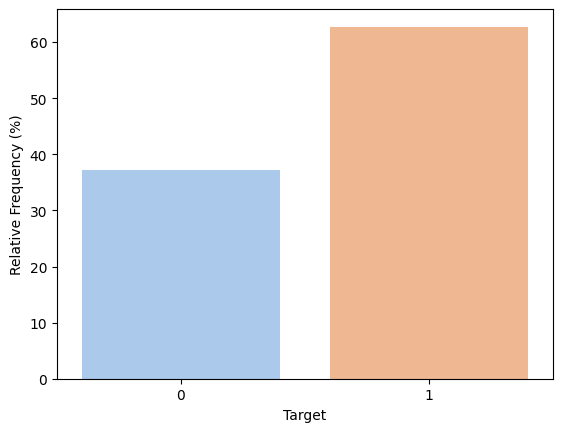

In [6]:
def balanced(df):
  """
    Percentage of people with Benign and malignant tumors
    Balanced or Imbalanced Data

    @p:
      df (dataframe): Input dataframe
  """

  ratio_df=(df[['ID','Target']].groupby('Target').count()/df.shape[0])*100

  ratio_df.reset_index(inplace=True)

  ratio_df.rename(columns={"ID": "Relative Frequency (%)"}, inplace=True)

  sns.barplot(data=ratio_df, x='Target', y="Relative Frequency (%)", palette="pastel")

  plt.savefig("/content/drive/MyDrive/output/balanced.png")

balanced(df)

**Undersampling**

In [7]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
df_under=pd.concat([X_under, y_under],ignore_index=True,axis=1)
df_under.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**PCA**

The first principle component explains 98% of the variance. The top 5 features from the component are 'worst area,' 'mean area,' 'area error,' 'worst perimeter,' and 'mean perimeter.'

In [8]:
pca = PCA(n_components=2)
X=X_under.to_numpy()
X=X[:,1:]
X = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2'], index=df.columns[1:-1])
loadings.sort_values(by=['PC1'], ascending=False)

Explained variation per principal component: [0.98067833 0.01743069]


,PC1,PC2
worst area,8.533078e-01,-5.181533e-01
mean area,5.147746e-01,8.527907e-01
area error,5.685372e-02,2.086433e-02
worst perimeter,4.862882e-02,-2.089477e-03
mean perimeter,3.440096e-02,5.997021e-02
worst radius,7.039204e-03,-9.652050e-04
mean radius,4.991449e-03,8.795706e-03
worst texture,2.898622e-03,-1.196997e-02
perimeter error,2.245901e-03,1.619017e-03
mean texture,2.101327e-03,-2.108246e-03


**Project Instances for Visualization**

The classes are not linearly separaple and there is some overlap between the benign and malignant cells. The malignant cells are very dispersed in there characteristics.

<Figure size 640x480 with 0 Axes>

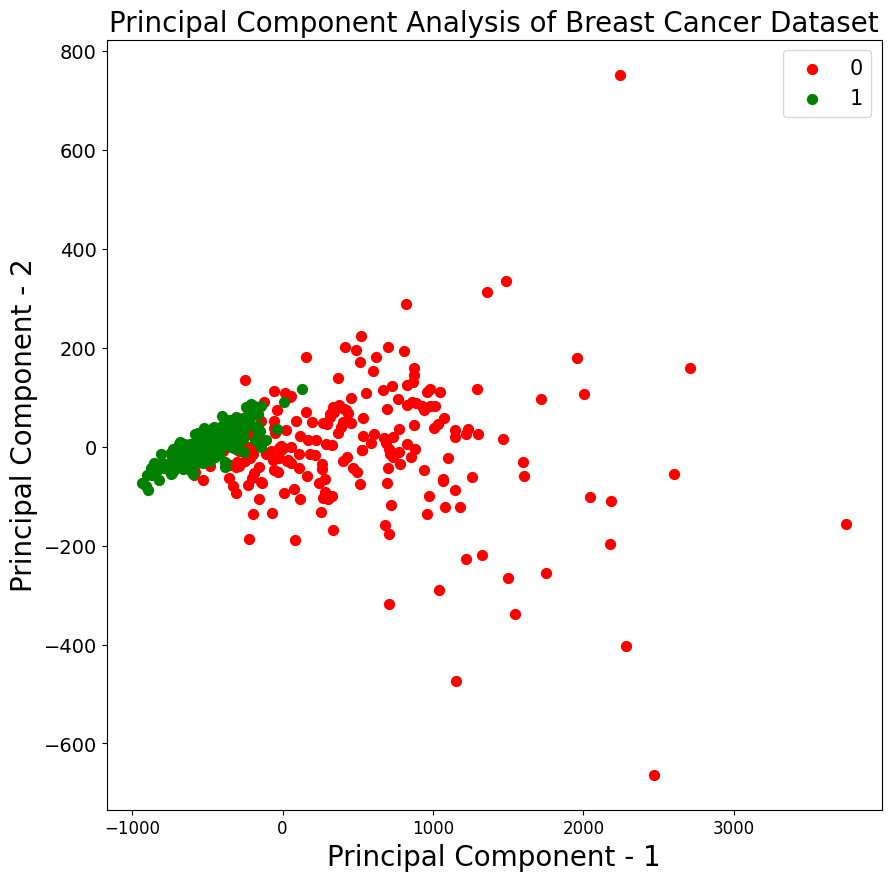

In [9]:
principalComponents_arr = pca.fit_transform(X)
principalComponents_df= pd.DataFrame(principalComponents_arr, columns = ['PC1','PC2'])

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    df_target=df_under[df_under[31] == target]
    indicesToKeep=df_target.index
    plt.scatter(principalComponents_df.loc[indicesToKeep, 'PC1'] , principalComponents_df.loc[indicesToKeep, 'PC2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.savefig("/content/drive/MyDrive/output/pca.png")

**Random Forest**

In [10]:
X_under_s=X_under[[ 'worst area', 'mean area','area error', 'worst perimeter', 'mean perimeter']]
X_train, X_test, y_train, y_test = train_test_split(X_under_s, y_under, test_size=0.5, random_state=0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf=clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

**Evaluation**

The accuracy is 0.92
Model AUC score: 0.919811320754717
Confusion Matrix
 [[ 95  11]
 [  6 100]]
The precision score: 0.9009009009009009

 The recall score: 0.9433962264150944 




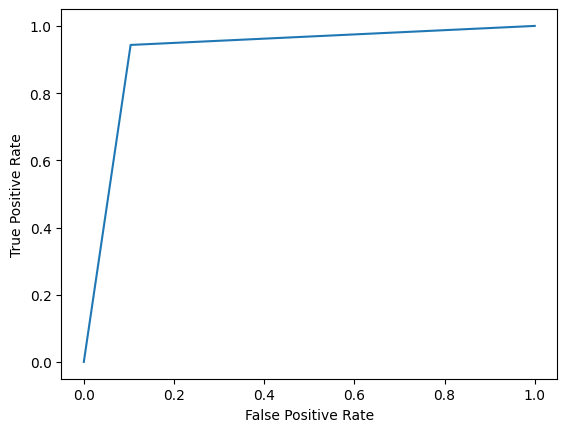

In [11]:
print("The accuracy is {}".format(round(accuracy_score(y_test, y_pred),2)))
def plot_roc_curve(true_y, y_prob):
    """
    Plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig("/content/drive/MyDrive/output/ROC_curve.png")

plot_roc_curve(y_test,y_pred)
print(f'Model AUC score: {roc_auc_score(y_test,y_pred)}')
cf_mat = confusion_matrix(y_test,y_pred)
print("Confusion Matrix\n",cf_mat)
print("The precision score: {}\n\n The recall score: {} \n\n".format(precision_score(y_test,y_pred), recall_score(y_test,y_pred)))

**Feature Importance**

Exact explainer: 213it [00:33,  6.30it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


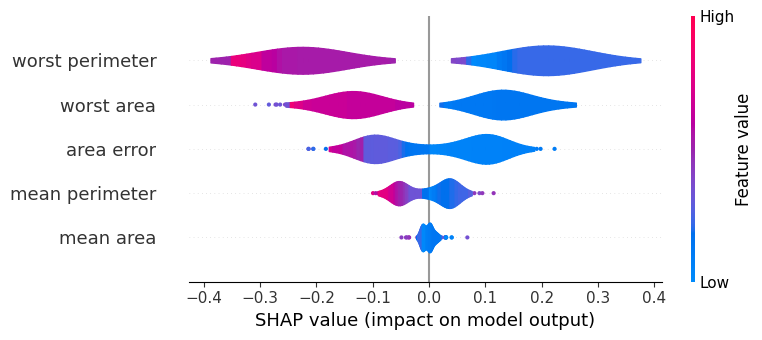

In [12]:
explainer = shap.Explainer(clf.predict,X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, plot_type='violin')

**References**

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/